In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

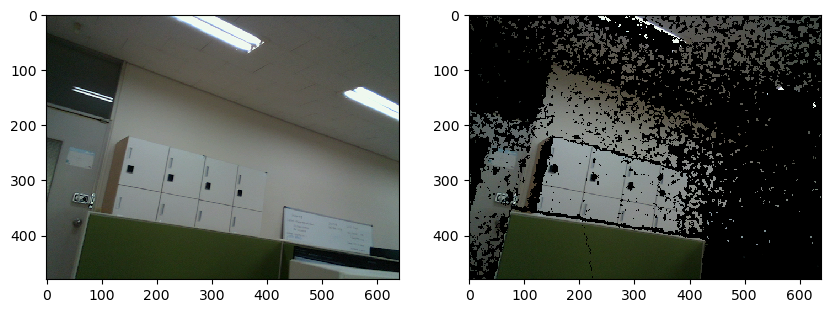

In [50]:
left_frame_names = ["color_frames/color_image" + str(700 + i) + ".png" for i in range(31)]
right_frame_names = ["right_frames/right_image" + str(700 + i) + ".png" for i in range(31)]

left_frames = []
right_frames = []
for i in range(31):
    left_frames.append(cv2.cvtColor(cv2.imread(left_frame_names[i]), cv2.COLOR_BGR2RGB))
    right_frames.append(cv2.cvtColor(cv2.imread(right_frame_names[i]), cv2.COLOR_BGR2RGB))

left_frame = left_frames[0]
right_frame = right_frames[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(left_frame)
axs[1].imshow(right_frame)
plt.show()

In [51]:
def make_matching_img(detector, left_frame, right_frame, dist_threshold):
    # find the keypoints and descriptors with ORB
    left_kp, left_desc = detector.detectAndCompute(left_frame, None)
    right_kp, right_desc = detector.detectAndCompute(right_frame, None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(left_desc, right_desc, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < dist_threshold*n.distance:
            good.append([m])

    matching_img = cv2.drawMatchesKnn(left_frame, left_kp, right_frame, right_kp, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return matching_img

In [ ]:
# ORB Detector
orb = cv2.ORB_create()

matching_images = []
for left_frame, right_frame in zip(left_frames, right_frames):
    orb_matching_img = make_matching_img(orb, left_frame, right_frame, 0.70)
    matching_images.append(orb_matching_img)

for idx, matching_image in enumerate(matching_images):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.imshow(matching_image)
    ax.set_title("frame No. " + str(700 + idx))
plt.show()

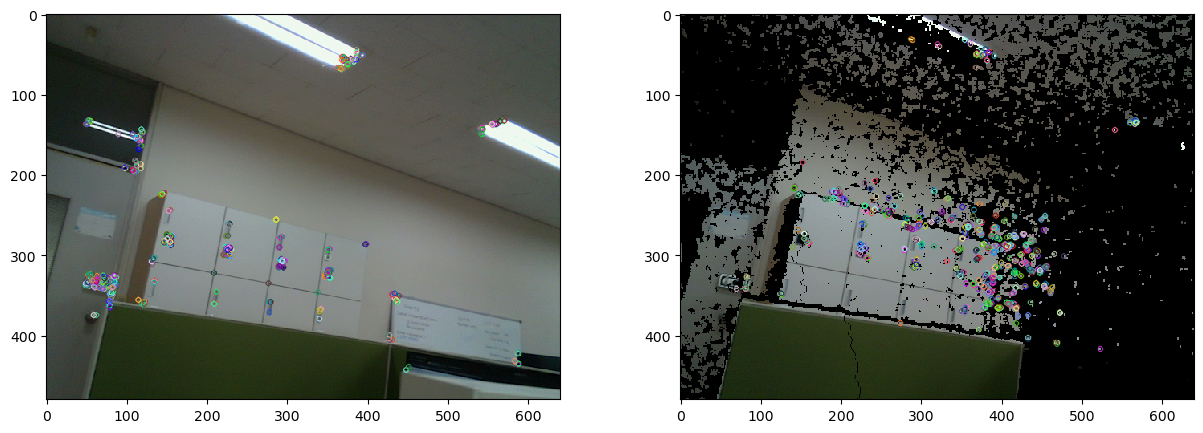

In [61]:
l_img = left_frames[0]
l_kp = orb.detect(l_img, None)
l_img_kp = cv2.drawKeypoints(l_img, l_kp, None, flags=0)

r_img = right_frames[0]
r_kp = orb.detect(r_img, None)
r_img_kp = cv2.drawKeypoints(r_img, r_kp, None, flags=0)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(l_img_kp)
axs[1].imshow(r_img_kp)
plt.show()

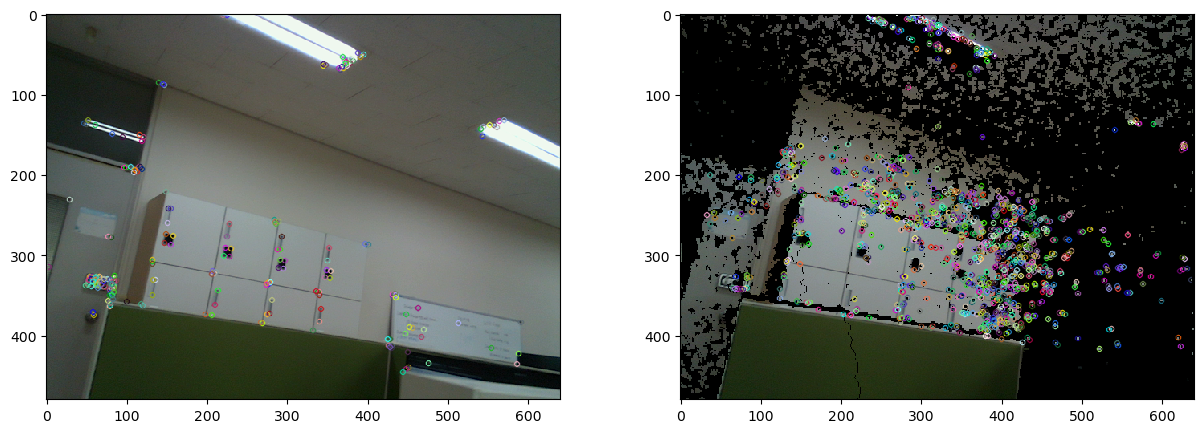

In [60]:
# GFTT Detector
gftt = cv2.GFTTDetector.create()

# matching_images = []
# for left_frame, right_frame in zip(left_frames, right_frames):
#     orb_matching_img = make_matching_img(gftt, left_frame, right_frame, 0.70)
#     matching_images.append(orb_matching_img)

# for idx, matching_image in enumerate(matching_images):
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#     ax.imshow(matching_image)
#     ax.set_title("frame No. " + str(700 + idx))

left_frame = left_frames[0]
right_frame = right_frames[0]

l_kp = gftt.detect(left_frame, None)
r_kp = gftt.detect(right_frame, None)

left_frame_kp = cv2.drawKeypoints(left_frame, l_kp, None)
right_frame_kp = cv2.drawKeypoints(right_frame, r_kp, None)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(left_frame_kp)
axs[1].imshow(right_frame_kp)
plt.show()

In [71]:
import yaml

yaml_filename = "/home/kodogyu/kimera_multi_ws/src/kimera_vio/params/L515_stereo/FrontendParams.yaml"
with open(yaml_filename, "r") as stream:
    stream.readline()  # %YAML:1.0 건너뛰기
    yaml_data = yaml.safe_load(stream)

print("type:", type(yaml_data))
print("feature_detector_type:", yaml_data["feature_detector_type"])
print("yaml file loaded.")

type: <class 'dict'>
feature_detector_type: 3


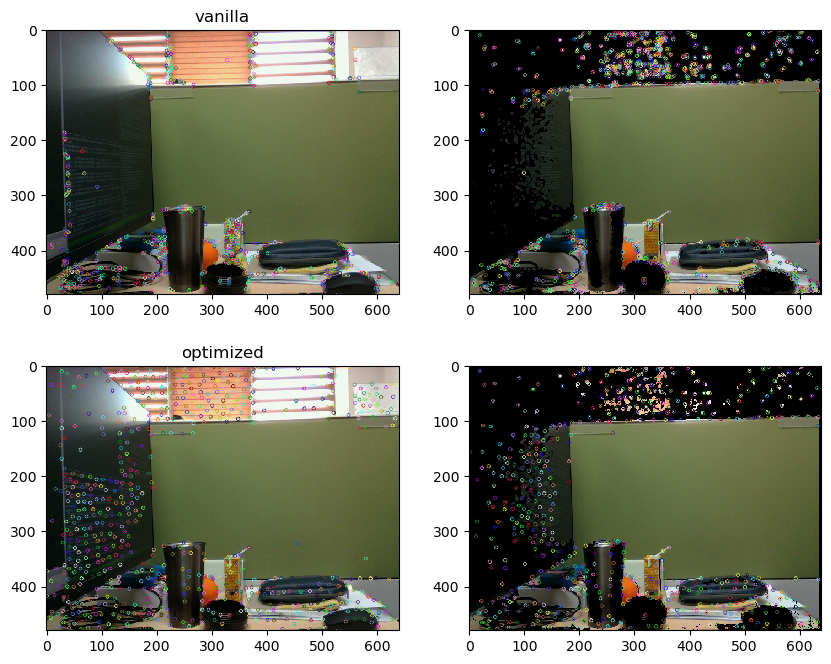

In [180]:
# Single image
left_key_frame = cv2.cvtColor(cv2.imread("color_frames/color_image484.png"), cv2.COLOR_BGR2RGB)
right_key_frame = cv2.cvtColor(cv2.imread("right_frames/right_image484.png"), cv2.COLOR_BGR2RGB)

gftt_detector = cv2.GFTTDetector.create(yaml_data["max_nr_keypoints_before_anms"], 
                                        yaml_data["quality_level"],
                                        10,  # yaml_data["min_distance_btw_tracked_and_detected_features"],
                                        yaml_data["block_size"],
                                        yaml_data["use_harris_detector"],
                                        yaml_data["k"])

lkf_kp_vanilla = gftt.detect(left_key_frame, None)
rkf_kp_vanilla = gftt.detect(right_key_frame, None)
lkf_kp = gftt_detector.detect(left_key_frame, None)
rkf_kp = gftt_detector.detect(right_key_frame, None)

left_key_frame_kp_v = cv2.drawKeypoints(left_key_frame, lkf_kp_vanilla, None)
right_key_frame_kp_v = cv2.drawKeypoints(right_key_frame, rkf_kp_vanilla, None)
left_key_frame_kp = cv2.drawKeypoints(left_key_frame, lkf_kp, None)
right_key_frame_kp = cv2.drawKeypoints(right_key_frame, rkf_kp, None)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].set_title("vanilla")
axs[0, 0].imshow(left_key_frame_kp_v)
axs[0, 1].imshow(right_key_frame_kp_v)
axs[1, 0].set_title("optimized")
axs[1, 0].imshow(left_key_frame_kp)
axs[1, 1].imshow(right_key_frame_kp)
plt.show()

In [181]:
def binning(keyPoints, numKptsToRetain, imgCols, imgRows, nr_horizontal_bins, nr_vertical_bins, binning_mask):
    binRowSize = imgRows / nr_vertical_bins
    binColSize = imgCols / nr_horizontal_bins

    nrActiveBins = binning_mask.sum()
    numRetPointsPerBin = round(numKptsToRetain / nrActiveBins)

    nrKptsInBin = np.zeros((nr_vertical_bins, nr_horizontal_bins))

    binnedKpts = []
    for i in range(len(keyPoints)):
        binRowInd = int(keyPoints[i].pt[1] // binRowSize)
        binColInd = int(keyPoints[i].pt[0] // binColSize)
        # if bin is active and needs more keypoints
        if (binning_mask[binRowInd, binColInd] == 1 and
            nrKptsInBin[binRowInd, binColInd] < numRetPointsPerBin): # if we need more kpts in that bin
            binnedKpts.append(keyPoints[i])
            nrKptsInBin[binRowInd, binColInd] += 1
        
    return binnedKpts


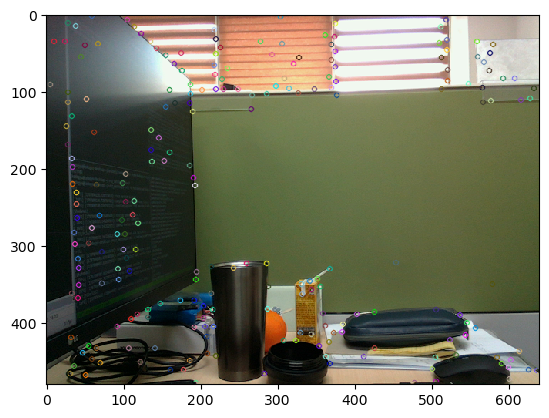

In [182]:
keyPointsSorted = sorted(lkf_kp, key=lambda x: x.response, reverse=True)

# binning_mask = np.ones((20, 28))
binning_mask = np.ones((yaml_data["nr_vertical_bins"], yaml_data["nr_horizontal_bins"]))
keypoints = binning(keyPointsSorted, 
                    yaml_data["maxFeaturesPerFrame"], 
                    640, 480, 
                    # 28,
                    # 20,
                    yaml_data["nr_horizontal_bins"], 
                    yaml_data["nr_vertical_bins"], 
                    binning_mask  # yaml_data["binning_mask"]
                    )

left_kf_maximum_suppression = cv2.drawKeypoints(left_key_frame, keypoints, None)
plt.imshow(left_kf_maximum_suppression)
plt.show()

/tmp/ipykernel_1466279/2378646395.py:14: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(left_kf_subpix, tuple(point), 3, (255, 0, 0), 2)


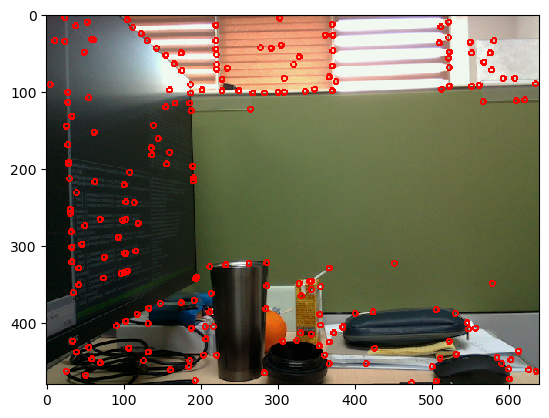

In [186]:
from copy import deepcopy
corners = cv2.KeyPoint_convert(keypoints)
window_size = yaml_data["window_size"]
zero_zone = yaml_data["zero_zone"]
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 10, 0.01)
corners = cv2.cornerSubPix(cv2.cvtColor(left_key_frame, cv2.COLOR_RGB2GRAY),
                                    corners,
                                    (window_size, window_size),
                                    (zero_zone, zero_zone),
                                    criteria)

left_kf_subpix = deepcopy(left_key_frame)
for point in corners:
    cv2.circle(left_kf_subpix, tuple(point), 3, (255, 0, 0), 2)
plt.imshow(left_kf_subpix)
plt.show()